# Best Algorithm

This notebook will test several algorithms and compare their performance. Afterwards, the best algorithm will be trained with different parameters.

We will use the 5 previous hours to train the models in the first phase. We will also only use one location, for faster development.

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    mean_absolute_percentage_error,
)

# import XGBoost
import xgboost as xgb

# import Gradient Boosting
from sklearn.ensemble import GradientBoostingRegressor

# import Artificial Neural Network
from sklearn.neural_network import MLPRegressor

# import LSTM
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM


/home/mcmatos/.local/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
df = pd.read_csv("BANES_cleaned_final.csv", parse_dates=["time"])
df.head()


,time,location,postcode,energy
0,2006-10-01 00:30:00+00:00,Bath Central Library Electricity (HH),BA1 5AL,5.9
1,2006-10-01 01:00:00+00:00,Guildhall Electricity Supply 1 (HH),BA1 5AW,33.0
2,2006-10-01 01:30:00+00:00,Guildhall Electricity Supply 1 (HH),BA1 5AW,32.7
3,2006-10-01 02:00:00+00:00,Guildhall Electricity Supply 1 (HH),BA1 5AW,32.2
4,2006-10-01 02:30:00+00:00,Bath Central Library Electricity (HH),BA1 5AL,5.9


In [3]:
df1 = df[["energy", "time", "location"]]

df1 = (
    df1.groupby(["time", "location"])
    .mean()
    .reset_index()
    .sort_values(by=["location", "time"])
)

# we need the last 10 rows (the last 5 hours)
for i in range(1, 11):
    df1[f"energy_{i}"] = df1.shift(i)["energy"]

df1.head()


,time,location,energy,energy_1,energy_2,energy_3,energy_4,energy_5,energy_6,energy_7,energy_8,energy_9,energy_10
78454,2008-06-14 00:30:00+00:00,## OLD Paulton Library Electricity Supply 1,0.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
78464,2008-06-14 01:00:00+00:00,## OLD Paulton Library Electricity Supply 1,0.07,0.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
78485,2008-06-14 02:30:00+00:00,## OLD Paulton Library Electricity Supply 1,0.08,0.07,0.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
78503,2008-06-14 03:30:00+00:00,## OLD Paulton Library Electricity Supply 1,0.08,0.08,0.07,0.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN
78513,2008-06-14 04:00:00+00:00,## OLD Paulton Library Electricity Supply 1,0.07,0.08,0.08,0.07,0.08,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# drop the first 10 rows of each location
locations = df1["location"].unique()

rows_to_delete = []

for location in locations:
    rows_to_delete.append(df1[df1["location"] == location].index[:48])

rows_to_delete = [i for index in rows_to_delete for i in index]
# drop rows, rows_to_delete contains their index
df1.drop(rows_to_delete, inplace=True)


In [5]:
max_location = df1["location"].value_counts().idxmax()

df_max = df1[df1["location"] == max_location]

df_max.head()


,time,location,energy,energy_1,energy_2,energy_3,energy_4,energy_5,energy_6,energy_7,energy_8,energy_9,energy_10
98,2006-10-02 08:30:00+00:00,Guildhall Electricity Supply 1 (HH),53.5,51.4,50.6,31.8,30.8,31.3,31.1,31.0,30.9,30.6,30.8
100,2006-10-02 09:00:00+00:00,Guildhall Electricity Supply 1 (HH),54.6,53.5,51.4,50.6,31.8,30.8,31.3,31.1,31.0,30.9,30.6
101,2006-10-02 09:30:00+00:00,Guildhall Electricity Supply 1 (HH),56.5,54.6,53.5,51.4,50.6,31.8,30.8,31.3,31.1,31.0,30.9
103,2006-10-02 10:00:00+00:00,Guildhall Electricity Supply 1 (HH),58.1,56.5,54.6,53.5,51.4,50.6,31.8,30.8,31.3,31.1,31.0
106,2006-10-02 11:00:00+00:00,Guildhall Electricity Supply 1 (HH),59.0,58.1,56.5,54.6,53.5,51.4,50.6,31.8,30.8,31.3,31.1


In [6]:
def pre_processing(df: pd.DataFrame, X_columns, y_columns, random=True, test_size=0.2):
    """Pre-processing function

    This function takes a dataframe and splits it into X and y.
    It also splits the data into train and test.

    Args:
        df: pandas dataframe
        X_columns: list of columns to be used as X
        y_columns: list of columns to be used as y
        random: boolean, if True, randomize the dataframe
        test_size: float, the size of the test set

    Returns:
        X_train: numpy array of X_train
        X_test: numpy array of X_test
        y_train: numpy array of y_train
        y_test: numpy array of y_test
    """
    X = df[X_columns]
    y = df[y_columns]

    if random:
        # split into train and test
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=42
        )
    else:
        # get first train size of data as train
        X_train = X.iloc[: int(X.shape[0] * (1 - test_size))]
        y_train = y.iloc[: int(y.shape[0] * (1 - test_size))]
        # get remaining data as test
        X_test = X.iloc[int(X.shape[0] * (1 - test_size)) :]
        y_test = y.iloc[int(y.shape[0] * (1 - test_size)) :]

    return X_train, X_test, y_train, y_test


def plot_results(preds: np.array, actuals: np.array, title: str):
    """Plotting function

    This function plots the predicted and actual values.

    Args:
        preds: numpy array of predicted values
        actuals: numpy array of actual values
    """
    plt.scatter(actuals, preds, c="b", label="predicted")
    plt.xlabel("actual")
    plt.ylabel("predicted")
    plt.title(title)
    plt.xlim(0, plt.xlim()[1])
    plt.ylim(0, plt.ylim()[1])
    _ = plt.plot([0, 100], [0, 100], "--r", label="y=x")
    plt.legend()
    plt.show()


def performance_metrics(preds: np.array, actuals: np.array):
    """Performance metrics function

    This function calculates the performance metrics.

    Args:
        preds: numpy array of predicted values
        actuals: numpy array of actual values
    """
    # calculate performance metrics
    mse = mean_squared_error(actuals, preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actuals, preds)
    wmape = np.sum(np.abs(actuals - preds)) / np.sum(np.abs(actuals))
    r2 = r2_score(actuals, preds)

    # print performance metrics
    print("MSE: %.4f" % mse)
    print("RMSE: %.4f" % rmse)
    print("MAE: %.4f" % mae)
    print("WMAPE: %.4f" % wmape)
    print("R2: %.4f" % r2)


### Scale the data

Use `MixMaxScaler` to scale the data.

In [7]:
scaler = MinMaxScaler()
df_values = df_max[["energy", *[f"energy_{i}" for i in range(1, 11)]]]
df_values = scaler.fit_transform(df_values)
df_values = pd.DataFrame(
    df_values, columns=["energy", *[f"energy_{i}" for i in range(1, 11)]]
)
df_values.head()


,energy,energy_1,energy_2,energy_3,energy_4,energy_5,energy_6,energy_7,energy_8,energy_9,energy_10
0,0.716198,0.688086,0.677376,0.425703,0.412316,0.419009,0.416332,0.414993,0.413655,0.409639,0.412316
1,0.730924,0.716198,0.688086,0.677376,0.425703,0.412316,0.419009,0.416332,0.414993,0.413655,0.409639
2,0.756359,0.730924,0.716198,0.688086,0.677376,0.425703,0.412316,0.419009,0.416332,0.414993,0.413655
3,0.777778,0.756359,0.730924,0.716198,0.688086,0.677376,0.425703,0.412316,0.419009,0.416332,0.414993
4,0.789826,0.777778,0.756359,0.730924,0.716198,0.688086,0.677376,0.425703,0.412316,0.419009,0.416332


## LSTM

Train an LSTM model with the last 5 hours of the data.

In [8]:
X_train, X_test, y_train, y_test = pre_processing(
    df_values,
    X_columns=[f"energy_{i}" for i in range(1, 11)],
    y_columns=["energy"],
    random=True,
    test_size=0.2,
)

X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

for i in range(5):
    print(X_train[i], y_train[i])


[0.33467202 0.3480589  0.37483266 0.40160643 0.42838019 0.48192771
 0.50870147 0.54886212 0.562249   0.54886212] [0.33467202]
[0.62516734 0.54350736 0.5167336  0.50468541 0.49799197 0.43373494
 0.43641232 0.4270415  0.41633199 0.40963855] [0.70950469]
[0.29049531 0.2811245  0.30120482 0.27710843 0.28514056 0.27978581
 0.29317269 0.29585007 0.28246319 0.28781794] [0.29986613]
[0.26104418 0.24230254 0.26104418 0.27576975 0.27576975 0.27175368
 0.27041499 0.2811245  0.27041499 0.29451138] [0.25435074]
[0.53681392 0.54484605 0.55957162 0.54350736 0.53012048 0.55823293
 0.5502008  0.5502008  0.56492637 0.55153949] [0.49129853]


In [9]:
n_features = 1
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], n_features)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], n_features)


In [10]:
from keras.layers import CuDNNLSTM


def create_lstm_model(X):
    """
    Build an LSTM model

    Args:
        X: pandas dataframe or numpy array, containing the data to train

    Returns:
        model: LSTM model
    """
    # define model
    model = Sequential()
    model.add(LSTM(5, return_sequences=True, input_shape=(X.shape[1], 1)))
    model.add(LSTM(5))
    model.add(Dense(1))
    model.compile(optimizer="adam", loss="mse", metrics=["mse"])
    return model


In [11]:
lstm_model = create_lstm_model(X_train)


2022-04-01 23:55:37.945786: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-01 23:55:38.024802: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-04-01 23:55:38.024832: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-04-01 23:55:38.034321: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN

In [12]:
# fit model
lstm_model.fit(X_train, y_train, epochs=25, batch_size=10)


Epoch 1/25
12244/12244 [==============================] - 288s 23ms/step - loss: 0.0027 - mse: 0.0027
Epoch 2/25
12244/12244 [==============================] - 354s 29ms/step - loss: 0.0013 - mse: 0.0013
Epoch 3/25
12244/12244 [==============================] - 141s 11ms/step - loss: 0.0011 - mse: 0.0011
Epoch 4/25
12244/12244 [==============================] - 138s 11ms/step - loss: 0.0010 - mse: 0.0010
Epoch 5/25
12244/12244 [==============================] - 144s 12ms/step - loss: 9.8834e-04 - mse: 9.8834e-04
Epoch 6/25
12244/12244 [==============================] - 154s 13ms/step - loss: 9.7245e-04 - mse: 9.7245e-04
Epoch 7/25
12244/12244 [==============================] - 165s 13ms/step - loss: 9.5236e-04 - mse: 9.5236e-04
Epoch 8/25
12244/12244 [==============================] - 178s 15ms/step - loss: 9.3702e-04 - mse: 9.3702e-04
Epoch 9/25
12244/12244 [==============================] - 181s 15ms/step - loss: 9.2965e-04 - mse: 9.2965e-04
Epoch 10/25
12244/12244 [=================

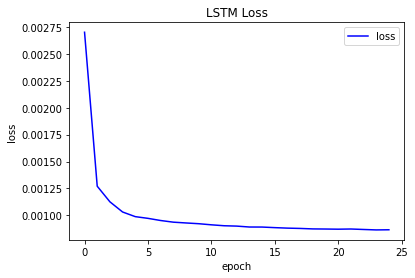

In [13]:
# plot loss
plt.plot(lstm_model.history.history["loss"], c="b")
plt.title("LSTM Loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["loss"])
plt.show()


In [14]:
# make predictions
preds = lstm_model.predict(X_test.reshape(X_test.shape[0], X_test.shape[1], 1))
# preds = scaler.inverse_transform(preds)


In [15]:
# append 10 columns of ones to preds
_preds = preds.copy()

for i in range(10):
    _preds = np.append(_preds, preds, axis=1)

print(_preds.shape)

_preds = scaler.inverse_transform(_preds)
# first column of each row
preds = _preds[:, 0]
preds[:10]


(30609, 11)


array([23.44001 , 26.89218 , 52.99465 , 20.977201, 39.82583 , 35.96551 ,
       35.760036, 27.09806 , 29.40143 , 32.301594], dtype=float32)

In [16]:
_y_test = y_test.copy()

for i in range(10):
    _y_test = np.append(_y_test, y_test, axis=1)

print(_y_test.shape)

_y_test = scaler.inverse_transform(_y_test)

_y_test = _y_test[:, 0]
_y_test[:10]


(30609, 11)


array([24.1, 23.4, 50.6, 19.6, 42.5, 36.3, 39.8, 29.1, 28.9, 31.5])

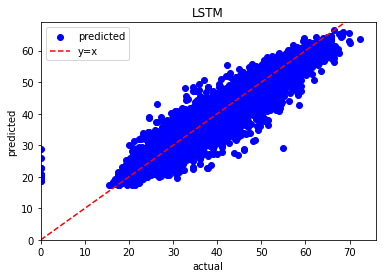

In [17]:
# plot results
plot_results(preds, _y_test, "LSTM")


In [18]:
# performance metrics
performance_metrics(preds, _y_test)


MSE: 4.8102
RMSE: 2.1932
MAE: 1.4833
WMAPE: 0.0442
R2: 0.9543


## ANN

Train the ANN model with the last 5 hours of the data.

In [19]:
def create_ann_model(X):
    """
    Build an ANN model

    Args:
        X: pandas dataframe or numpy array, containing the data to train

    Returns:
        model: ANN model
    """
    # define model
    model = Sequential()
    model.add(Dense(10, input_dim=X.shape[1], activation="relu"))
    model.add(Dense(10, activation="relu"))
    model.add(Dense(1))
    model.compile(optimizer="adam", loss="mse", metrics=["mse"])
    return model


In [20]:
ann_model = create_ann_model(X_train)


In [21]:
# fit model
ann_model.fit(X_train, y_train, epochs=25, batch_size=10)


Epoch 1/25
12244/12244 [==============================] - 25s 2ms/step - loss: 0.0014 - mse: 0.0014
Epoch 2/25
12244/12244 [==============================] - 25s 2ms/step - loss: 9.6328e-04 - mse: 9.6328e-04
Epoch 3/25
12244/12244 [==============================] - 23s 2ms/step - loss: 9.3064e-04 - mse: 9.3064e-04
Epoch 4/25
12244/12244 [==============================] - 18s 2ms/step - loss: 9.0721e-04 - mse: 9.0721e-04
Epoch 5/25
12244/12244 [==============================] - 15s 1ms/step - loss: 8.9494e-04 - mse: 8.9494e-04
Epoch 6/25
12244/12244 [==============================] - 15s 1ms/step - loss: 8.9015e-04 - mse: 8.9015e-04
Epoch 7/25
12244/12244 [==============================] - 15s 1ms/step - loss: 8.8023e-04 - mse: 8.8023e-04
Epoch 8/25
12244/12244 [==============================] - 19s 2ms/step - loss: 8.7434e-04 - mse: 8.7434e-04
Epoch 9/25
12244/12244 [==============================] - 17s 1ms/step - loss: 8.6985e-04 - mse: 8.6985e-04
Epoch 10/25
12244/12244 [===========

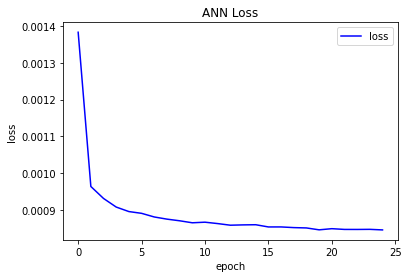

In [22]:
# plot loss
plt.plot(ann_model.history.history["loss"], c="b")
plt.title("ANN Loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["loss"])
plt.show()


In [23]:
# make predictions
preds = ann_model.predict(X_test)


In [24]:
# append 10 columns of ones to preds
_preds = preds.copy()

for i in range(10):
    _preds = np.append(_preds, preds, axis=1)

print(_preds.shape)

_preds = scaler.inverse_transform(_preds)
# first column of each row
preds = _preds[:, 0]
preds[:10]


(30609, 11)


array([23.585554, 28.0471  , 53.48356 , 21.119387, 40.645733, 36.83156 ,
       37.629505, 27.96006 , 29.554152, 32.421627], dtype=float32)

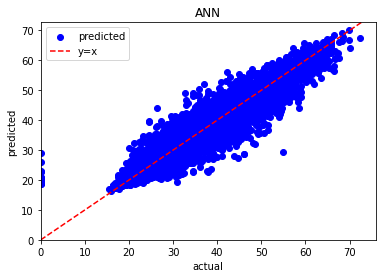

In [25]:
# plot results
plot_results(preds, _y_test, "ANN")


In [26]:
# performance metrics
performance_metrics(preds, _y_test)


MSE: 4.8144
RMSE: 2.1942
MAE: 1.4621
WMAPE: 0.0435
R2: 0.9542


## Gradient Boosting

Train the Gradient Boosting model with the last 5 hours of the data.

In [27]:
def create_gbdt_model():
    """
    Build an GBDT model

    Args:
        X: pandas dataframe or numpy array, containing the data to train

    Returns:
        model: GBDT model
    """
    # define model
    model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1)
    return model


In [28]:
gbdt_model = create_gbdt_model()


In [29]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])
y_train = y_train.reshape(y_train.shape[0])
y_test = y_test.reshape(y_test.shape[0])


In [30]:
gbdt_model.fit(X_train, y_train)


GradientBoostingRegressor()

In [31]:
# make predictions
preds = gbdt_model.predict(X_test)


In [32]:
_preds = preds.copy()

_preds = _preds.reshape(_preds.shape[0], 1)

for i in range(10):
    _preds = np.append(_preds, preds.reshape(preds.shape[0], 1), axis=1)

print(_preds.shape)

_preds = scaler.inverse_transform(_preds)
preds = _preds[:, 0]
preds[:10]


(30609, 11)


array([22.97520229, 26.96600113, 53.43249186, 20.64531573, 39.66864181,
       35.52933425, 35.75939672, 27.22145623, 29.56371331, 32.52344154])

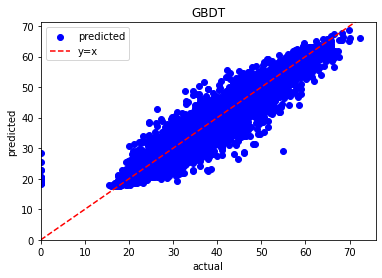

In [33]:
# plot results
plot_results(preds, _y_test, "GBDT")


In [34]:
# performance metrics
performance_metrics(preds, _y_test)


MSE: 4.6371
RMSE: 2.1534
MAE: 1.4406
WMAPE: 0.0429
R2: 0.9559


## XGBoost

Apply the XGBoost model with the last 5 hours of the data.

In [35]:
def create_xgboost_model():
    """
    Build an XGBoost model

    Args:
        X: pandas dataframe or numpy array, containing the data to train

    Returns:
        model: XGBoost model
    """
    # define model
    model = xgb.XGBRegressor(max_depth=5, learning_rate=0.1, n_estimators=100, verbosity=1, seed=42)
    return model


In [36]:
xgboost_model = create_xgboost_model()


In [37]:
xgboost_model.fit(X_train, y_train)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=1)

In [38]:
preds = xgboost_model.predict(X_test)


In [39]:
# append 10 columns of ones to preds
_preds = preds.copy()

_preds = _preds.reshape(_preds.shape[0], 1)

for i in range(10):
    _preds = np.append(_preds, preds.reshape(preds.shape[0], 1), axis=1)

print(_preds.shape)

_preds = scaler.inverse_transform(_preds)
preds = _preds[:, 0]
preds[:10]


(30609, 11)


array([22.980518, 27.112368, 53.733967, 20.619675, 39.79522 , 36.02729 ,
       36.10729 , 26.932436, 29.49307 , 32.49065 ], dtype=float32)

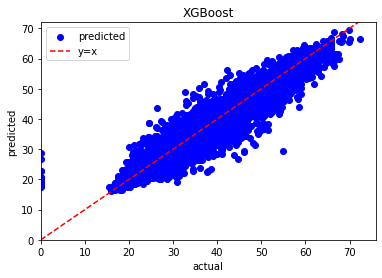

In [40]:
# plot results
plot_results(preds, _y_test, "XGBoost")


In [41]:
# performance metrics
performance_metrics(preds, _y_test)


MSE: 4.5059
RMSE: 2.1227
MAE: 1.4168
WMAPE: 0.0422
R2: 0.9572
